In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# CELL 1: Data Loading & Standardization
# Rationale: Cleaning noise and normalizing features to prevent binary-bias.
def preprocess_parkinsons_data(file_path):
    df = pd.read_csv(file_path)
    
    # 1. Dropping non-clinical identifiers and demographic noise (Ethnicity, IDs)
    drop_cols = ['PatientID', 'Ethnicity', 'DoctorInCharge']
    df_cleaned = df.drop(columns=[c for c in drop_cols if c in df.columns])
    
    # 2. Separating Diagnosis (Target) from clinical features
    diagnosis = df_cleaned['Diagnosis']
    features = df_cleaned.drop(columns=['Diagnosis'])
    
    # 3. Applying StandardScaler (Z-score)
    # This centers each feature around 0, ensuring binary features don't dominate Age/BMI.
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features)
    
    # 4. Rebuilding the DataFrame
    final_df = pd.DataFrame(scaled_data, columns=features.columns)
    final_df['Diagnosis'] = diagnosis.values
    
    # Pre-calculating composite clinical indices for later analysis
    final_df['Vulnerability_Index'] = final_df['BMI'] + final_df['Depression']
    final_df['Resilience_Score'] = final_df['PhysicalActivity'] + final_df['DietQuality'] + final_df['SleepQuality']
    final_df['Clinical_Risk_Score'] = final_df[['UPDRS', 'TraumaticBrainInjury', 'Diabetes', 'PosturalInstability', 'Depression']].sum(axis=1)
    
    return final_df

df = preprocess_parkinsons_data('parkinsons_preprocessed.csv')
print("Preprocessing complete. 31 Features standardized.")

INFO: Loading and processing parkinsons_cleaned.csv
INFO: Updated preprocessing complete! Saved to parkinsons_preprocessed.csv


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# CELL 1: Data Loading & Standardization
# Rationale: Cleaning noise and normalizing features to prevent binary-bias.
def preprocess_parkinsons_data(file_path):
    df = pd.read_csv(file_path)
    
    # 1. Dropping non-clinical identifiers and demographic noise (Ethnicity, IDs)
    drop_cols = ['PatientID', 'Ethnicity', 'DoctorInCharge']
    df_cleaned = df.drop(columns=[c for c in drop_cols if c in df.columns])
    
    # 2. Separating Diagnosis (Target) from clinical features
    diagnosis = df_cleaned['Diagnosis']
    features = df_cleaned.drop(columns=['Diagnosis'])
    
    # 3. Applying StandardScaler (Z-score)
    # This centers each feature around 0, ensuring binary features don't dominate Age/BMI.
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features)
    
    # 4. Rebuilding the DataFrame
    final_df = pd.DataFrame(scaled_data, columns=features.columns)
    final_df['Diagnosis'] = diagnosis.values
    
    # Pre-calculating composite clinical indices for later analysis
    final_df['Vulnerability_Index'] = final_df['BMI'] + final_df['Depression']
    final_df['Resilience_Score'] = final_df['PhysicalActivity'] + final_df['DietQuality'] + final_df['SleepQuality']
    final_df['Clinical_Risk_Score'] = final_df[['UPDRS', 'TraumaticBrainInjury', 'Diabetes', 'PosturalInstability', 'Depression']].sum(axis=1)
    
    return final_df

df = preprocess_parkinsons_data('parkinsons_preprocessed.csv')
print("Preprocessing complete. 31 Features standardized.")

Preprocessing complete. 31 Features standardized.


In [12]:
# CELL 2: Step 1 - Multidimensional Risk Clustering
# Defining clinical profiles using K-Means (k=4)
cluster_features = ['UPDRS', 'MoCA', 'FunctionalAssessment', 'Tremor', 'Rigidity', 
                    'PosturalInstability', 'PhysicalActivity', 'DietQuality', 
                    'SleepQuality', 'Diabetes', 'Depression', 'TraumaticBrainInjury']

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df[cluster_features])

# Summary statistics per cluster
cluster_stats = df.groupby('Cluster').agg({
    'Diagnosis': 'mean',
    'UPDRS': 'mean',
    'Vulnerability_Index': 'mean'
}).rename(columns={'Diagnosis': 'Diagnosis_Rate'}).sort_values('Diagnosis_Rate', ascending=False)

print("STEP 1: Cluster Risk Profiles identified.")
print(cluster_stats)

STEP 1: Cluster Risk Profiles identified.
         Diagnosis_Rate     UPDRS  Vulnerability_Index
Cluster                                               
2              0.796226 -0.105438             0.037488
3              0.757953  0.024539            -0.024619
0              0.651786  0.049288             0.013183
1              0.446809 -0.000942             0.005501


In [13]:
# CELL 3: Step 2 - The Tipping Point (Healthy vs. Sick within same cluster)
tipping_results = []
for c in range(4):
    c_subset = df[df['Cluster'] == c]
    healthy = c_subset[c_subset['Diagnosis'] == 0][cluster_features].mean()
    sick = c_subset[c_subset['Diagnosis'] == 1][cluster_features].mean()
    
    # Identifying the 'Trigger' (Highest in sick) and 'Protector' (Highest in healthy)
    gap = sick - healthy
    tipping_results.append({
        'Cluster': c,
        'Primary_Trigger': gap.idxmax(),
        'Primary_Protector': gap.idxmin()
    })

print("STEP 2: Tipping Point factors discovered for each Risk Tier.")
print(pd.DataFrame(tipping_results))

STEP 2: Tipping Point factors discovered for each Risk Tier.
   Cluster Primary_Trigger     Primary_Protector
0        0           UPDRS                  MoCA
1        1           UPDRS  FunctionalAssessment
2        2           UPDRS                  MoCA
3        3           UPDRS  FunctionalAssessment


In [14]:
# CELL 4: Step 3 - Identifying "Super-Resilient" Outliers
# Patients in the top 10% Risk Category who avoided diagnosis (Diagnosis=0)
risk_threshold = df['Clinical_Risk_Score'].quantile(0.90)
resilient_outliers = df[(df['Clinical_Risk_Score'] >= risk_threshold) & (df['Diagnosis'] == 0)]
sick_high_risk = df[(df['Clinical_Risk_Score'] >= risk_threshold) & (df['Diagnosis'] == 1)]

# Characterizing Resilience Factors
factors = ['PhysicalActivity', 'DietQuality', 'SleepQuality', 'EducationLevel', 'MoCA']
resilience_profile = pd.DataFrame({
    'Feature': factors,
    'Super_Resilient': [resilient_outliers[f].mean() for f in factors],
    'Sick_High_Risk': [sick_high_risk[f].mean() for f in factors]
})

print(f"STEP 3: Found {len(resilient_outliers)} Super-Resilient individuals.")
print(resilience_profile)

STEP 3: Found 37 Super-Resilient individuals.
            Feature  Super_Resilient  Sick_High_Risk
0  PhysicalActivity         0.062809        0.050328
1       DietQuality        -0.125526       -0.072242
2      SleepQuality         0.124574       -0.056127
3    EducationLevel         0.377817        0.091833
4              MoCA         0.489239       -0.157391


INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_16581/3540780461.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_summary.index, y=cluster_summary['Diagnosis_Rate'], palette='Reds_r', ax=axes[0])
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


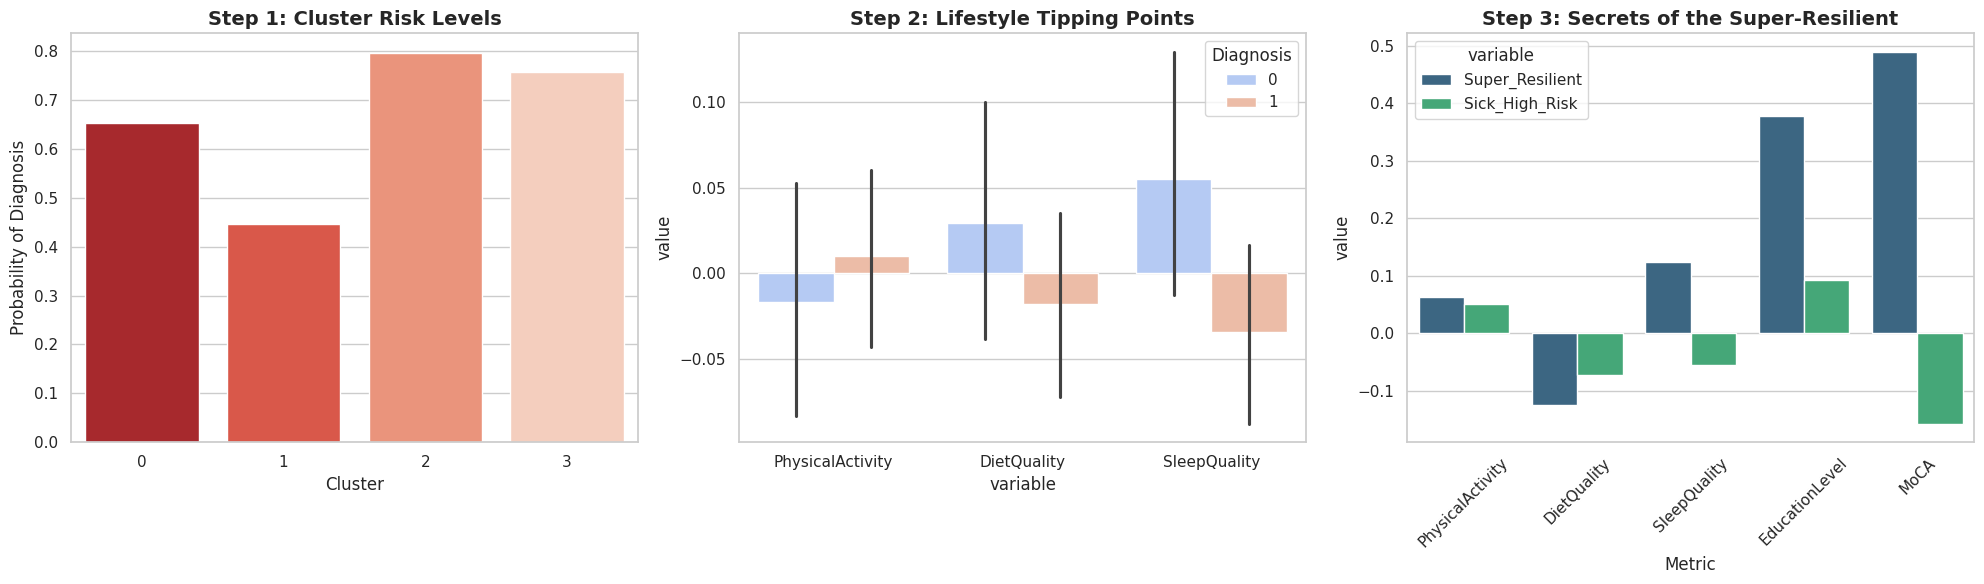

In [ ]:

sns.set(style="whitegrid")

# Load data
df = pd.read_csv('parkinsons_preprocessed.csv')

# Pre-calculating indices for analysis
df['Vulnerability_Index'] = df['BMI'] + df['Depression']
df['Risk_Score'] = df[['UPDRS', 'TraumaticBrainInjury', 'Diabetes', 'PosturalInstability', 'Depression']].sum(axis=1)

# ---------------------------------------------------------
# STEP 1: Multidimensional Risk Clustering
# ---------------------------------------------------------
clustering_features = [
    'UPDRS', 'MoCA', 'FunctionalAssessment', 'Tremor', 'Rigidity', 
    'PosturalInstability', 'PhysicalActivity', 'DietQuality', 
    'SleepQuality', 'Diabetes', 'Depression', 'TraumaticBrainInjury'
]
X = df[clustering_features]

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

cluster_summary = df.groupby('Cluster').agg({
    'Diagnosis': 'mean',
    'UPDRS': 'mean',
    'Vulnerability_Index': 'mean'
}).rename(columns={'Diagnosis': 'Diagnosis_Rate'}).sort_values('Diagnosis_Rate', ascending=False)

# ---------------------------------------------------------
# STEP 2: The Tipping Point Analysis
# ---------------------------------------------------------
tipping_results = []
for c in range(4):
    c_data = df[df['Cluster'] == c]
    healthy = c_data[c_data['Diagnosis'] == 0][clustering_features].mean()
    sick = c_data[c_data['Diagnosis'] == 1][clustering_features].mean()
    
    diff = sick - healthy
    tipping_results.append({
        'Cluster': c,
        'Trigger': diff.idxmax(),
        'Protector': diff.idxmin()
    })
tipping_df = pd.DataFrame(tipping_results)

# ---------------------------------------------------------
# STEP 3: Identifying Super-Resilient Outliers
# ---------------------------------------------------------
# Top 10% Risk Score but Diagnosis = 0
threshold = df['Risk_Score'].quantile(0.9)
super_resilient = df[(df['Risk_Score'] >= threshold) & (df['Diagnosis'] == 0)]
sick_high_risk = df[(df['Risk_Score'] >= threshold) & (df['Diagnosis'] == 1)]

res_comp = pd.DataFrame({
    'Metric': ['PhysicalActivity', 'DietQuality', 'SleepQuality', 'EducationLevel', 'MoCA'],
    'Super_Resilient': [super_resilient[m].mean() for m in ['PhysicalActivity', 'DietQuality', 'SleepQuality', 'EducationLevel', 'MoCA']],
    'Sick_High_Risk': [sick_high_risk[m].mean() for m in ['PhysicalActivity', 'DietQuality', 'SleepQuality', 'EducationLevel', 'MoCA']]
})

# ---------------------------------------------------------
# VISUALIZATION DASHBOARD
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Diagnosis Rate by Tier
sns.barplot(x=cluster_summary.index, y=cluster_summary['Diagnosis_Rate'], palette='Reds_r', ax=axes[0])
axes[0].set_title('Step 1: Cluster Risk Levels', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Probability of Diagnosis')

# Plot 2: Tipping Point - Lifestyle Impact
lifestyle_vars = ['PhysicalActivity', 'DietQuality', 'SleepQuality']
melted_df = df.melt(id_vars=['Diagnosis'], value_vars=lifestyle_vars)
sns.barplot(data=melted_df, x='variable', y='value', hue='Diagnosis', palette='coolwarm', ax=axes[1])
axes[1].set_title('Step 2: Lifestyle Tipping Points', fontweight='bold', fontsize=14)

# Plot 3: Resilience Profile (Healthy Outliers vs Sick High-Risk)
res_melted = res_comp.melt(id_vars='Metric')
sns.barplot(data=res_melted, x='Metric', y='value', hue='variable', palette='viridis', ax=axes[2])
plt.setp(axes[2].get_xticklabels(), rotation=45)
axes[2].set_title('Step 3: Secrets of the Super-Resilient', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()